In [4]:
!pip install numpy~=1.21.1

In [5]:
!pip install torch~=1.8.0

In [1]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            1.0.0
alabaster                          0.7.12
anaconda-client                    1.9.0
anaconda-navigator                 1.10.0
anaconda-project                   0.10.2
anyio                              2.2.0
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
arrow                              0.13.1
asn1crypto                         1.4.0
astroid                            2.6.6
astropy                            5.0
astunparse                         1.6.3
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              21.4.0
autopep8                           1.6.0
Babel                              2.

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import torch

In [10]:
from model import BraggNN

In [11]:
# load a pre-trained model
model  = BraggNN(imgsz=11, fcsz=(16, 8, 4, 2)) # should use the same argu as it in the training.
mdl_fn = 'bragg_final_model.pth'

# may need to replace torch.load with torch.jit.loadif it doesn't work
model.load_state_dict(torch.load(mdl_fn, map_location=torch.device('cpu')))

<All keys matched successfully>

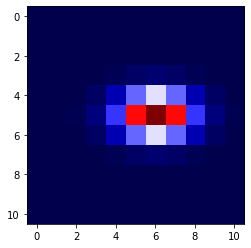

In [12]:
# use a simple gaussian for demo
# node that models in this repo are pre-trained with real experiment data
# the simple gaussian data may not simplify anything but makes a challenge to the model
# as the train data and testing data are not IID.
X_test = np.zeros((11, 11))
x_cen, y_cen = 6.0, 5.0

sig_x, sig_y = 0.6, 1.5
for x in range(11):
    for y in range(11):
        X_test[y][x] = 1000*(np.exp(-(x-x_cen)*(x-x_cen)/2*sig_x -(y-y_cen)*(y-y_cen)/2*sig_y))

# the input needs to be normalize to 0-1, e.g., rescale using min-max norm
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

plt.imshow(X_test, cmap='seismic')
plt.show(); plt.close()

In [5]:
input_tensor = torch.from_numpy(X_test[np.newaxis, np.newaxis].astype('float32'))
with torch.no_grad():
    pred = model.forward(input_tensor).cpu().numpy()

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [6]:
# scale back peak location by multiply with patch size
res = pred * 11

In [7]:
res

array([[5.9369993, 5.1481276]], dtype=float32)

In [8]:
!pip install --upgrade dlhub-sdk

  Using cached dlhub_sdk-0.10.2-py2.py3-none-any.whl (42 kB)
  Using cached funcx-0.3.9-py3-none-any.whl (53 kB)
     |████████████████████████████████| 184 kB 3.9 MB/s eta 0:00:01
  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
  Using cached texttable-1.6.4-py2.py3-none-any.whl (10 kB)
  Using cached fair_research_login-0.2.6-py2.py3-none-any.whl (28 kB)
  Using cached PyJWT-2.4.0-py3-none-any.whl (18 kB)
  Using cached typing_extensions-4.2.0-py3-none-any.whl (24 kB)
  Using cached globus_nexus_client-0.4.1-py3-none-any.whl (9.2 kB)
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 1.7.1
    Uninstalling PyJWT-1.7.1:
      Successfully uninstalled PyJWT-1.7.1
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: globus-sdk
    Found existing installation: globus-sdk 2.0.1
    Uninstall

# Publish to DLHub

In [10]:
# copied to inference.py, no longer needed in notebook
def run_inference(input_data):
    import numpy as np
    from matplotlib import pyplot as plt
    import torch
    from model import BraggNN


    # load a pre-trained model
    model  = BraggNN(imgsz=11, fcsz=(16, 8, 4, 2)) # should use the same argu as it in the training.
    mdl_fn = 'bragg_final_model.pth'

    # may need to replace torch.load with torch.jit.loadif it doesn't work
    model.load_state_dict(torch.load(mdl_fn, map_location=torch.device('cpu')))

    input_tensor = torch.from_numpy(input_data)
    with torch.no_grad():
        pred = model.forward(input_tensor).cpu().numpy()

    # scale back peak location by multiply with patch size
    return pred * 11

In [1]:
# get the pointer to the inference function
from inference import run_inference

In [2]:
from dlhub_sdk import DLHubClient
from dlhub_sdk.models.servables.python import PythonStaticMethodModel

dl = DLHubClient()
model = PythonStaticMethodModel.from_function_pointer(run_inference)

In [3]:
# set model basics
# first (BraggNN_one_peak_test) could not find inference in __main__ (I think?)
# 2 included proper visibility group, also included inference.py as new file, also added all necessary files to servable
# 3 included matplotlib in requirements, also included scaling of predictions
# 4 remove matplotlib from reqs and from imports (getting a certifi error again) -- now it works!
# 5 is republished with DLHub X (v0.10.0)
model_name = 'BraggNN_PT_CPU'
model_title = 'PyTorch BraggNN for CPU'
model.set_name(model_name).set_title(model_title)

model.set_creators(['Ravi, Nikil',
                    'Chaturvedi, Pranshu',
                    'Huerta, E.A.',
                    'Liu, Zhengchun',
                    'Scourtas, Aristana',
                    'Schmidt, KJ',
                    'Chard, Ryan',
                    'Blaiszik, Ben'])

# set model visibility -- keep it private for now, set to internal Globus group
# model.set_visibility(groups=['e42501dd-22eb-11ec-8133-25fb1049fcf5'])

# set description of inputs to model, and outputs
model.set_inputs('ndarray', 'Image map', shape=([11, 11]))
model.set_outputs('ndarray', 'list of Bragg peak positions', shape=([1, 2]))

# set package requirements
model.add_requirement('numpy', '1.21.1')
model.add_requirement('torch', '1.8.0')

# add any files necessary for inference
model.add_file('bragg_final_model.pth')
model.add_file('model.py')
model.add_file('inference.py')
model.add_file('util.py')

PythonStaticMethodModel(dlhub=DLHubMetadata(version='0.10.0', domains=[], visible_to=['public'], name='BraggNN_PT_CPU', files={'other': ['bragg_final_model.pth', 'model.py', 'inference.py', 'util.py']}, dependencies={'python': {'numpy': '1.21.1', 'torch': '1.8.0'}}, test=None, type='servable'), datacite=Datacite(identifier=DataciteIdentifier(identifier='10.datacite/placeholder', identifierType=<DataciteIdentifierType.DOI: 'DOI'>), creators=[DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=[], familyName='Ravi', givenName='Nikil'), DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=[], familyName='Chaturvedi', givenName='Pranshu'), DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=[], familyName='Huerta', givenName='E.A.'), DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=[], familyName='Liu', givenName='Zhengchun'), DataciteCreator(creatorName=None, nameIdentifiers=[], affiliations=[], familyName='Scourtas', givenName

In [4]:
model._get_type()


'Python static method'

In [5]:
from dlhub_sdk.utils.schemas import validate_against_dlhub_schema

validate_against_dlhub_schema(model.to_dict(), 'servable')

In [6]:
res = dl.publish_servable(model)
res

'4b92f988-1cd0-4514-ae33-7e94005026f3'

# Run in DLHub

In [15]:
dl.run('aristana_uchicago/BraggNN_PT_CPU', X_test[np.newaxis, np.newaxis].astype('float32'))

array([[5.9369993, 5.1481276]], dtype=float32)

In [14]:
dl.run('aristana_uchicago/noop_v14', True)

'Hello world!'